In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import numpy as np
from tqdm import tqdm


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("../data/", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)
IM_SIZE = 28*28
IM_SHAPE = (28, 28)

In [4]:

# Just a simple PCA, works a little bit some pictures can be red.
# EPOCH = 3, Batch = 10 and cross_entropie         => loss = 310206
# EPOCH = 10, Batch = 50 and cross_entropie        => loss = 314635
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_en = nn.Linear(IM_SIZE, 16)
        self.fc1_de = nn.Linear(16, IM_SIZE)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1_en(x))
        return F.sigmoid(self.fc1_de(x))
                
net = Net()
print(net)  


Net(
  (fc1_en): Linear(in_features=784, out_features=16, bias=True)
  (fc1_de): Linear(in_features=16, out_features=784, bias=True)
)


In [5]:

# Simple PCA weights are tied. 
# EPOCH = 10, Batch = 10 and cross_entropie        => loss = 280169
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IM_SIZE, 16)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return F.sigmoid(F.linear(x, self.fc1.weight.transpose(0,1), bias=None))
                
net = Net()
print(net)  

Net(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
)


In [6]:

# 1 hidden layer and dropout:
# EPOCH = 3, Batch = 10 and mse                    => loss = 244880
# EPOCH = 3, Batch = 10 and cross_entropie         => loss = 192187
# EPOCH = 10, Batch = 10 and cross_entropie        => loss = 171493
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_en = nn.Linear(IM_SIZE, 64)
        self.fc2_en = nn.Linear(64, 16)
        self.fc1_de = nn.Linear(16, 64)
        self.fc2_de = nn.Linear(64, IM_SIZE)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.dropout(x)
        x = F.sigmoid(self.fc1_en(x))
        x = F.sigmoid(self.fc2_en(x))
        x = F.sigmoid(self.fc1_de(x))
        return F.sigmoid(self.fc2_de(x))
                
net = Net()
print(net)  

Net(
  (fc1_en): Linear(in_features=784, out_features=64, bias=True)
  (fc2_en): Linear(in_features=64, out_features=16, bias=True)
  (fc1_de): Linear(in_features=16, out_features=64, bias=True)
  (fc2_de): Linear(in_features=64, out_features=784, bias=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


In [7]:
# 1 hidden layer, dropout and tied weights:
# EPOCH = 10, Batch = 10 and cross_entropie        => loss = 238903
# EPOCH = 100, Batch = 10 and cross_entropie        => loss = 174692
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IM_SIZE, 64)
        self.fc2 = nn.Linear(64, 16)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.dropout(x)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(F.linear(x, self.fc2.weight.transpose(0,1), bias=None))
        return F.sigmoid(F.linear(x, self.fc1.weight.transpose(0,1), bias=None))
                
net = Net()
print(net)  

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
EPOCHS = 3

for epoch in range(EPOCHS):
    for X, _ in tqdm(trainset):
        net.zero_grad()
        output = net(X.view(-1, IM_SIZE))
        loss = F.binary_cross_entropy(output, X.view(-1, IM_SIZE), reduction='sum')
        loss.backward()
        optimizer.step()
    print(epoch, loss)

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|▍                                                                              | 36/6000 [00:00<00:17, 350.45it/s]

0 tensor(1934.7849, grad_fn=<BinaryCrossEntropyBackward>)


  1%|▌                                                                              | 41/6000 [00:00<00:14, 399.12it/s]

1 tensor(1889.6864, grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:15<00:00, 378.44it/s]

2 tensor(1925.0247, grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 836.26it/s]


tensor(521235.9375)


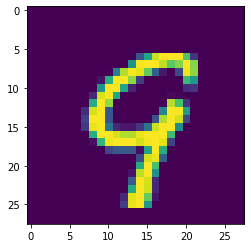

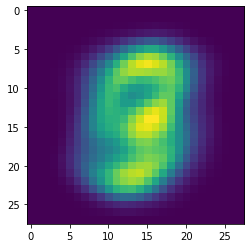

In [9]:
loss = 0
with torch.no_grad():
    for X, _ in tqdm(testset):
        output = net(X.view(-1, IM_SIZE))
        loss += F.mse_loss(output, X.view(-1, IM_SIZE), reduction='sum')

print(loss)
plt.imshow(X[0].view(IM_SHAPE))
plt.show()
plt.imshow(output[0].view(IM_SHAPE))
plt.show()


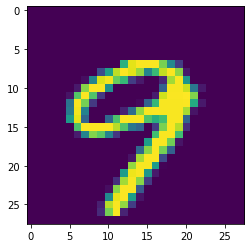

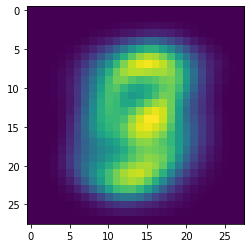

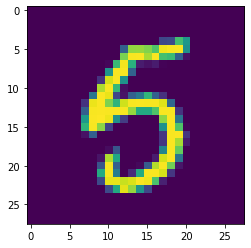

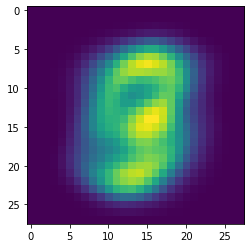

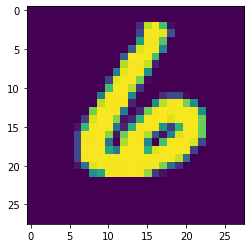

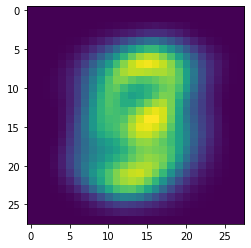

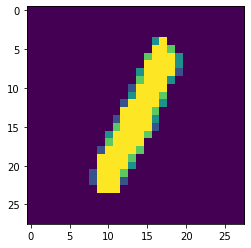

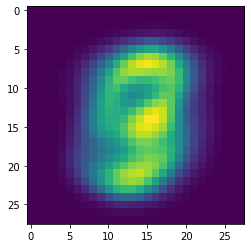

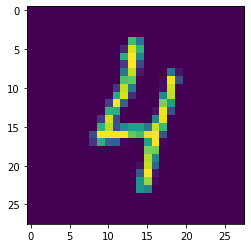

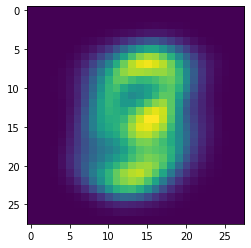

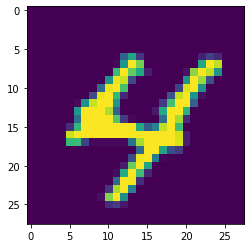

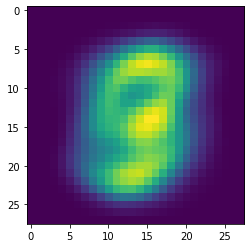

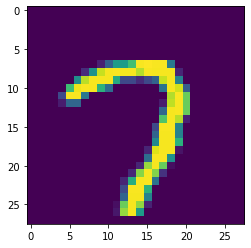

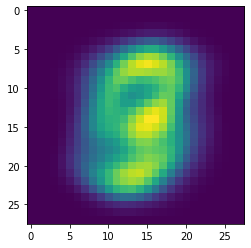

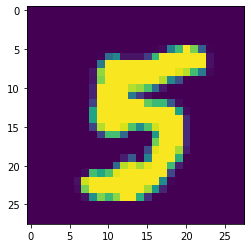

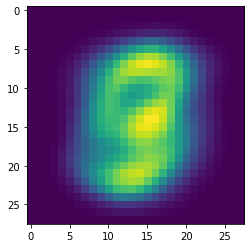

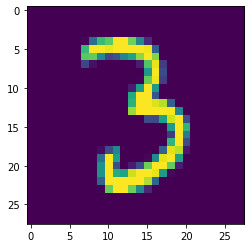

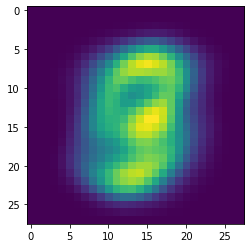

In [10]:
for i in range(1,10):
    plt.imshow(X[i].view(IM_SHAPE))
    plt.show()
    plt.imshow(output[i].view(IM_SHAPE))
    plt.show()
